In [ ]:
# We will use RIM-ONE and DRISHTI dataset

In [ ]:
# I have obtained the dataset from the following github page, which is open source by the way
# Git Hub URL: https://github.com/seva100/optic-nerve-cnn
# Data URL: https://drive.google.com/drive/folders/13g62bhqN1JHJ2fky2Xy5avLbZ2YLMdwB

In [ ]:
# we will start coding by mounting the google drive and setting up configurations 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Initial Setup

train=True
Epochs=30
preload=False
hough=False
rams=False
dynAug=False
depth = 6
chan = 64
ir = 1.1
rand_sv = 42
ds = 'MIX'
zone = 'CUP'
cup = True
mix = True
dri = False
rim = False

In [ ]:
print(depth,chan,ir,rand_sv,ds,zone)

6 64 1.1 42 MIX CUP


In [ ]:
# Import all the necessary libraries

import tensorflow as tf
import os
import glob
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, Lambda, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter, ellipse
from skimage.measure import  ransac, EllipseModel

In [ ]:
# boiler plate code configuration for TPU or GPU selection

print("Tensorflow version " + tf.__version__)
if 'COLAB_TPU_ADDR' in os.environ:
  print(os.environ['COLAB_TPU_ADDR'])
else:
  print('No TPU')
if(tf.test.is_gpu_available()):
  gpu=True
else:
  gpu=False
  print('No GPU')

Tensorflow version 2.3.0
10.89.77.58:8470
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU


In [ ]:
# Metrics and further helper functions below

In [ ]:
# let's set tensorflow backend working type to be float

K.set_floatx('float32')

In [ ]:
# Metrics for evaluation

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
def dice_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

# Computes mean Intersection-over-Union (IOU) for two arrays of binary images.

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# helper function to increase the brightness
# hue, saturation, value

def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

In [ ]:
# helper code to shuffle

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
# helper code to 512 image size indices with original images

def index512_resize(index,top):
  index=index*top/512
  return int(index)

In [ ]:
# Load the data
h5f1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), '/content/gdrive/My Drive/Medical Image/cnn_term_paper', 'RIM_ONE_v3.hdf5'), 'r')
h5f2 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), '/content/gdrive/My Drive/Medical Image/cnn_term_paper', 'DRISHTI_GS.hdf5'), 'r')
h5v1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), '/content/gdrive/My Drive/Medical Image/cnn_term_paper', 'DRIONS_DB.hdf5'), 'r')

In [ ]:
# Let's define the U-Net Model

In [ ]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input(( img_rows, img_cols,3))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis = -1)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis = -1)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis = -1)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# We can find data preprocessing steps below
# step1: prepare the data for our model injection
# step2: Create train and test set by combining datasets
# Step3: Preprocessing step for Cup Segmentation
# step4: Shuffle the dataset
# step5: Increase the size of dataset by Image Data Generator

In [ ]:
img_shape=(128,128,3)

In [ ]:
# DRISHTI Dataset
# step1: prepare the data for our model injection

Xori= np.asarray(h5f2['DRISHTI-GS/orig/images'])
disc_locations = np.asarray( h5f2['DRISHTI-GS/512 px/disc_locations'])
FC = np.asarray(h5f2['DRISHTI-GS/512 px/file_codes'] ) 
indDRI = np.arange(0,Xori.shape[0])
bsqside=np.maximum((disc_locations[:,3]-disc_locations[:,1]),(disc_locations[:,2]-disc_locations[:,0]))
isize=Xori.shape[1]

if (cup):
  
  Yf = np.asarray(h5f2['DRISHTI-GS/512 px/cup'])
 
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][0]+bsqside[i],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][1]+bsqside[i],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][0]+bsqside[i], disc_locations[i][1]:disc_locations[i][1]+bsqside[i]] 
                   for i in range(len(Xori))]

else:
  Yf =np.asarray( h5f2['DRISHTI-GS/512 px/disc'])
  
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

X=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym
#get binary mask
Yb=(Y>0.5).astype(np.float32) 

print(np.amax(Yf),np.amin(Yf))
print(X.shape)

1.0 0.0
1.0 0.0
(50, 128, 128, 3)


In [ ]:
# RIM ONE V_3 Dataset
# step1: prepare the data for our model injection

Xvori= h5f1['RIM-ONE v3/orig/images']
disc_locationsv = h5f1['RIM-ONE v3/512 px/disc_locations']
Glauv=np.asarray(h5f1['RIM-ONE v3/512 px/is_ill'] )
FCv=np.asarray(h5f1['RIM-ONE v3/512 px/file_codes'])
indRIM=np.arange(0,Xvori.shape[0])
bsqsidev=np.maximum((disc_locationsv[:,3]-disc_locationsv[:,1]),(disc_locationsv[:,2]-disc_locationsv[:,0]))
low_cont_n=0;
ivsize=Xvori.shape[1]

if (cup):

  Yvf = h5f1['RIM-ONE v3/512 px/cup']

  Xvc = [Xvori[i][index512_resize(disc_locationsv[i][0],ivsize):index512_resize(disc_locationsv[i][0]+bsqsidev[i],ivsize), index512_resize(disc_locationsv[i][1],ivsize):index512_resize(disc_locationsv[i][1]+bsqsidev[i],ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][disc_locationsv[i][0]:disc_locationsv[i][0]+bsqsidev[i], disc_locationsv[i][1]:disc_locationsv[i][1]+bsqsidev[i]] 
                     for i in range(len(Xvori))]

else:

  Yvf = h5f1['RIM-ONE v3/512 px/disc']

  Xvc = [Xvori[i][index512_resize(50,isize):index512_resize(462,ivsize), index512_resize(50,isize):index512_resize(462,ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][50:462,50:462] 
                     for i in range(len(Xvori))]


Xvn=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xvc]
Xv=np.asarray(Xvn) 
am=np.amax(Xv)
Xv=Xv.astype(np.float32)/am 
print(np.amax(Xv),np.amin(Xv))

Yv=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yvc]
Yv=np.asarray(Yv) 
ym=np.amax(Yv) 
Yvf=(Yv/ym).astype(np.float32) 

print(np.amax(Yvf),np.amin(Yvf))
print(Xv.shape)

1.0 0.0
1.0 0.0
(159, 128, 128, 3)


In [ ]:
# step2: Create train and test set by combining datasets

rng = np.random.RandomState(rand_sv)

#DRISHTI
X_train1t, X_test1t, Y_train1t, Y_test1t, F_train1t, F_test1t ,ind_train1, ind_test1= train_test_split( X, Yb, FC, indDRI,test_size=0.25,random_state=rng)

#RIM ONE
X_train2, X_test2, Y_train2, Y_test2, F_train2, F_test2, ind_train2, ind_test2= train_test_split( Xv, Yvf, FCv, indRIM, test_size=0.25,random_state=rng)

X_test_dri=np.copy(X_test1t)
Y_test_dri=np.copy(Y_test1t)
F_test_dri=np.copy(F_test1t)

X_test_rim=np.copy(X_test2)
Y_test_rim=np.copy(Y_test2)
F_test_rim=np.copy(F_test2)

if(dri or mix):
  X_train1=np.concatenate([X_train1t,X_train1t])
  X_train1=np.concatenate([X_train1,X_train1t])
  X_test1=np.concatenate([X_test1t,X_test1t])
  X_test1=np.concatenate([X_test1,X_test1t])

  Y_train1=np.concatenate([Y_train1t,Y_train1t])
  Y_train1=np.concatenate([Y_train1,Y_train1t])
  Y_test1=np.concatenate([Y_test1t,Y_test1t])
  Y_test1=np.concatenate([Y_test1,Y_test1t])

if(mix):
  X_train1=np.concatenate([X_train1,X_train2])
  Y_train1=np.concatenate([Y_train1,Y_train2])
  X_test1=np.concatenate([X_test1,X_test2])
  Y_test1=np.concatenate([Y_test1,Y_test2])

  X_train1=np.concatenate([X_train1,X_train2])
  Y_train1=np.concatenate([Y_train1,Y_train2])
  X_test1=np.concatenate([X_test1,X_test2])
  Y_test1=np.concatenate([Y_test1,Y_test2])

if(rim):
  X_train1=np.concatenate([X_train2,X_train2])
  X_test1=np.concatenate([X_test2,X_test2])

  Y_train1=np.concatenate([Y_train2,Y_train2])
  Y_test1=np.concatenate([Y_test2,Y_test2])

if(dri):
  X_train1=np.concatenate([X_train1,X_train1])
  Y_train1=np.concatenate([Y_train1,Y_train1])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test1)
Y_test=np.asarray(Y_test1)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((20*size, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((20*size, 128, 128, 1),dtype=np.float32) 

In [ ]:
# Step3: Preprocessing step for Cup Segmentation
# Perform CLAHE on each image

for i in range(16):
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.04)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.02)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((20*sizev, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((20*sizev, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.04)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.02)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1

In [ ]:
# step4: Shuffle the dataset

X_trains,Y_trains = unison_shuffled_copies(X_traine, Y_traine)
X_tests,Y_tests = unison_shuffled_copies(X_teste, Y_teste)

In [ ]:
# Provide the same seed and keyword arguments to the fit and flow methods

seed = rand_sv
batch_s = 120

In [ ]:
# We can find model training and evaluation steps below

In [ ]:
# helper function for ipython notebook

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper/last_check_point.hdf5'), verbose=1, save_best_only=True,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=2e-4)

In [ ]:
img_shape

(128, 128, 3)

In [ ]:
# Boiler plate code to enable TPU or GPU in Google Colab
# initialise GPU or TPU

if 'COLAB_TPU_ADDR' not in  os.environ:
  if (gpu):
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  else:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
else:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)

model = get_unet_light(img_rows=128, img_cols=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001, ),
    loss=log_dice_loss, metrics=[dice_coef]
    )

INFO:tensorflow:Initializing the TPU system: grpc://10.89.77.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.77.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# Understand the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
# if(preload):
#   model.load_weights(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper/model2_cup_last_check_point.hdf5'))

In [ ]:
X_tests.shape

(2380, 128, 128, 3)

In [ ]:
# Model Training Step 

if(train):
  history = model.fit(
    X_trains,Y_trains,
    epochs=Epochs,
    batch_size=128,
    steps_per_epoch=35,
    validation_data = (X_tests,Y_tests),
    callbacks=[cp_callbacks,reduce_lr],
    verbose=1
  )

# save the trained model weights
model.save_weights(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper/model2_cup_last_check_point.hdf5'), overwrite=True)

Epoch 1/30
 2/35 [>.............................] - ETA: 1:20 - loss: 1.4710 - dice_coef: 0.2299WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 4.8984s). Check your callbacks.


35/35 [==============================] - ETA: 0s - loss: 0.9755 - dice_coef: 0.4016WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.4934s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 0.37100, saving model to /content/gdrive/My Drive/Medical Image/cnn_term_paper/last_check_point.hdf5
35/35 [==============================] - 179s 5s/step - loss: 0.9755 - dice_coef: 0.4016 - val_loss: 0.3710 - val_dice_coef: 0.6901
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.3924 - dice_coef: 0.6758
Epoch 00002: val_loss did not improve from 0.37100
35/35 [==============================] - 171s 5s/step - loss: 0.3924 - dice_coef: 0.6758 - val_loss: 0.7316 - val_dice_coef: 0.4817
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.3599 - dice_coef: 0.6978
Epoch 00003: val_loss did not improve from 0.37100
35/35 [==============================] - 173s 5s/step - loss: 0.3599 - dice_coef: 0.6978 - val_loss: 0.6088 - val_dice_coef: 0.5442
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.3323 - dice_coef: 0.7177
Epoch 00004: val_loss did not improve from 0.37100
35/35 [==============

In [ ]:
# Load the pre trained model's weights

if(train):
  model.load_weights(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper/model2_cup_last_check_point.hdf5'))

In [ ]:
# evaluate the model with the test data

result = model.evaluate(X_tests[0:700,:,:,:],Y_tests[0:700,:,:,:])
print("log dice loss for test set = ", result[0], ' ||| ',"dice coeffecient (accuracy) for test set = ", result[1])

 2/22 [=>............................] - ETA: 2s - loss: 0.4350 - dice_coef: 0.6480WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0007s vs `on_test_batch_end` time: 0.0965s). Check your callbacks.


22/22 [==============================] - 2s 103ms/step - loss: 0.4421 - dice_coef: 0.6453
log dice loss for test set =  0.44206303358078003  |||  dice coeffecient (accuracy) for test set =  0.6453490257263184


In [ ]:
# Visualise the change in accuracies and losses during training 

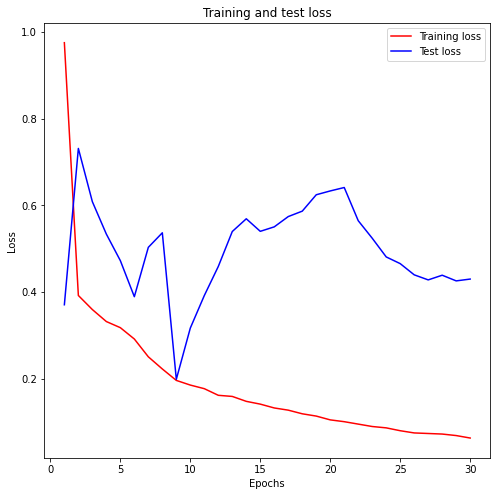

In [ ]:
# plot train and test log dice loss

if(train):
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  acc=history.history['dice_coef']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper','loss'+'model2_cup'+'.png'),dpi=600)

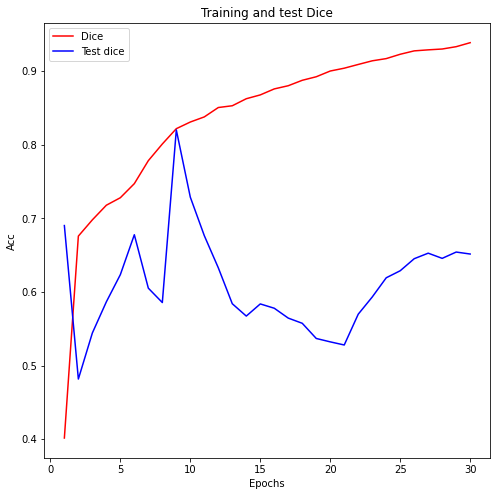

In [ ]:
# plot train and test dice coeffecient (accuracy)
if(train):
  loss = history.history['loss']
  acc=history.history['dice_coef']
  val_acc=history.history['val_dice_coef']
  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, acc, 'r', label='Dice')
  plt.plot(epochs, val_acc, 'b', label='Test dice')
  plt.title('Training and test Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  plt.savefig(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper','hist'+'model2_cup'+'.png'),dpi=600)

### We will Visualise how our algorithm performs on our Combined test set

In [ ]:
test_s=int(X_testc.shape[0])
test_s=test_s-test_s%8
test_s

112

In [ ]:
# Defining metrics again

smooth=1e-07
def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )
    
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )   

In [ ]:
# importing helper libraries for visualisation part

from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

(112, 128, 128, 3)



Dice mean= 0.83547586  Std= 0.103501074  best= 0.9616514  worst= 0.5241682
IOU mean= 0.73005486  Std= 0.14256199  best= 0.92613536  worst= 0.35516796
image #11
0.9616514
image #39
0.5241682
CPU times: user 4.77 s, sys: 25.1 ms, total: 4.8 s
Wall time: 5.63 s


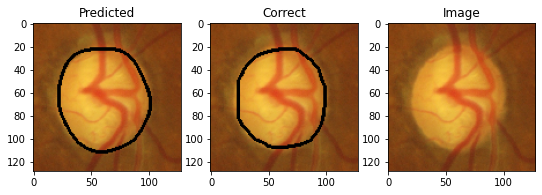

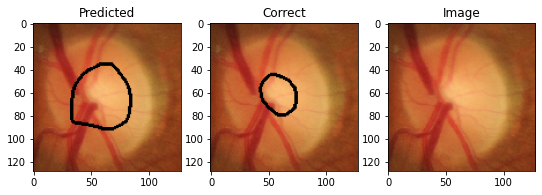

In [ ]:
%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_testc[0:test_s]
batch_y = Y_testc[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()


for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test[i]
    pred1 = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred1)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    fig.savefig(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper','img_test_set'+str(j)+'model2_cup'+'.png'),dpi=600)
    j+=1



### Visualise our segmentation algorithm performs on RIM ONE dataset

In [ ]:
test_s=int(X_test_rim.shape[0])
test_s

40

(40, 128, 128, 3)



Dice mean= 0.80241454  Std= 0.09940979  best= 0.9423816  worst= 0.5241682
IOU mean= 0.6809287  Std= 0.13192643  best= 0.8910413  worst= 0.35516796
image #26
0.9423816
image #0
0.5241682


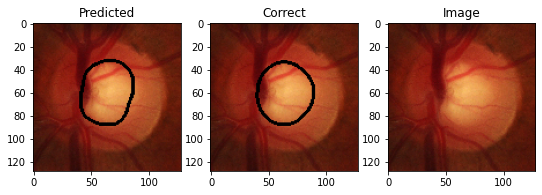

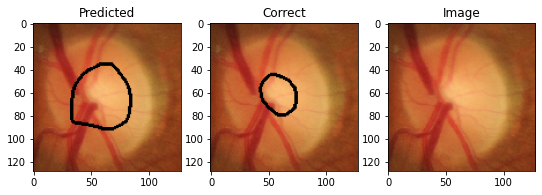

In [ ]:

pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_rim[0:test_s]
batch_y = Y_test_rim[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_rim[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_rim[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    fig.savefig(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper','img_rim_one'+str(j)+'model2_cup'+'.png'),dpi=600)
    j+=1

### Visualise our segmentation algorithm performs on DRISHTI dataset

In [ ]:
test_s=int(X_test_dri.shape[0])
test_s

13

(13, 128, 128, 3)



Dice mean= 0.90240574  Std= 0.07061479  best= 0.9616514  worst= 0.67507553
IOU mean= 0.8287271  Std= 0.10222741  best= 0.92613536  worst= 0.50952005
image #11
0.9616514
image #7
0.67507553


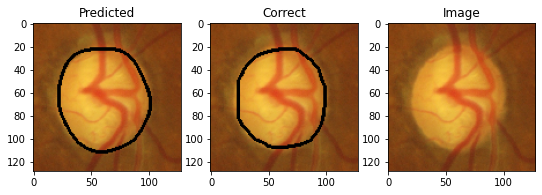

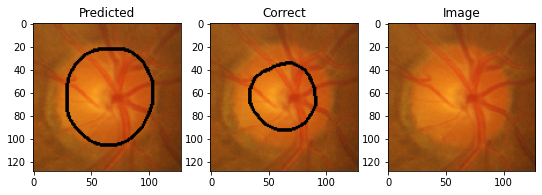

In [ ]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    fig.savefig(os.path.join('/content/gdrive/My Drive/Medical Image/cnn_term_paper','img_drishti'+str(j)+'model2_cup'+'.png'),dpi=600)
    j+=1